In [1]:
import random
import numpy as np


Nstates=4
Nactions=2
'''
transition_kernel= np.zeros((Nstates,Nactions),dtype=object)

#probality, sprime
transition_kernel[0][0] = [(0.9,1),(0.1,2)]
transition_kernel[0][1] = [(1,3)] 
transition_kernel[1][0] = [(0.9,0),(0.1,1)]
transition_kernel[1][1] = [(1,2)] 
transition_kernel[2][0] = [(1,2)] 
transition_kernel[2][1] = [(1,2)] 
transition_kernel[3][0] = [(1,3)] 
transition_kernel[3][1] = [(1,3)] 


#rewards
rewards=np.zeros(Nstates,dtype=float)
rewards[0] = 50.
rewards[1] = 10.
rewards[2] = 20.
rewards[3] = 10.
'''
'''
Nstates = 4
Nactions = 4
steps=2
transition_kernel = np.zeros((Nstates,Nactions),dtype=object)

transition_kernel[0][0] = [(0.8,0),(0.10,1),(0.10,0)]
transition_kernel[0][1] = [(0.8,2),(0.10,1),(0.10,0)]
transition_kernel[0][2] = [(0.8,0),(0.10,0),(0.10,2)]
transition_kernel[0][3] = [(0.8,1),(0.10,0),(0.10,2)]
transition_kernel[1][0] = [(0.8,1),(0.10,0),(0.10,1)]
transition_kernel[1][1] = [(0.8,3),(0.10,0),(0.10,1)]
transition_kernel[1][2] = [(0.8,0),(0.10,1),(0.10,3)]
transition_kernel[1][3] = [(0.8,1),(0.10,1),(0.10,3)]
#state 2 is a hole , in the quantum setting we remain the agent in the same state with zero reward.
transition_kernel[2][0] = [(1,2)]
transition_kernel[2][1] = [(1,2)]
transition_kernel[2][2] = [(1,2)]
transition_kernel[2][3] = [(1,2)]
#state 3 is the goal state, so the agent remains in the goal state with 2 reward
transition_kernel[3][0] = [(1,3)]
transition_kernel[3][1] = [(1,3)]
transition_kernel[3][2] = [(1,3)]
transition_kernel[3][3] = [(1,3)]
rewards=np.zeros(Nstates,dtype=float)
rewards[2] = -1.0
rewards[3] = 2.0
'''

from random_mdp_generator import random_mdp

mdp = random_mdp(n_states = Nstates , n_actions=Nactions)

transition_kernel, rewards = mdp.create(r_max=20)
tk = mdp.get_mdpR()

# For the sampling mode randomly get an outcome for an action
# this is where the stochastic transition model kicks in
with open('mdp2.npy', 'wb') as f:
    np.save(f, transition_kernel  ,allow_pickle = True) 
    np.save(f, rewards  ,allow_pickle = True) 
    np.save(f, tk  ,allow_pickle = True) 

In [1]:
import random
import numpy as np


Nstates=4
Nactions=2
#mdp1 test.npy mdp2 - mdp2.npy
with open('mdp2.npy', 'rb') as f:
    transition_kernel = np.load(f ,allow_pickle = True) 
    rewards = np.load(f ,allow_pickle = True) 
    tk = np.load(f ,allow_pickle = True) 

In [2]:
def rnd_get_outcome(state, action):
    # build the cdf over the action possible outcomes
    cdf=[]
    accumulated_p = 0
    for outcome in transition_kernel[state][action]:
        accumulated_p += outcome[0]  # accumulate the probability of the outcome
        cdf.append(accumulated_p)
        
    # now get a uniform sample in [0..1[
    r = random.random()
    # locate the corresponding entry in the cdf: that is the desired outcome
    for ndx,value in enumerate(cdf):
        if r<value: break

    next_state = transition_kernel[state][action][ndx][1]
    return next_state


# randomly select one among all possible actions
# return the action and the probabilioty with which it was selected
def rnd_sample_action(state):
    # unformly select one among the possible actions. pdf = 1/Nactions
    new_action = random.randrange(Nactions)    
    pdf = 1/Nactions
    
    return new_action, pdf 

# sample a distribution
def rnd_sample_dist(dist):    
    # unformly select one among the possible actions. pdf = 1/N
    Csi = random.random() 
    for i, prob in enumerate(dist):
        if prob>Csi: break
    
    return i


In [3]:
horizon = 3
discount = 0.9
initial_state = 0
NSamplesList = [1,2,5,10,50,100,200,300,500]
N_experiments = 3000

In [4]:
def eval_action_GOD (state, action, depth):
    expected_reward = 0  # across all possible outcomes
    for outcome in transition_kernel[state][action]:
        next_state = outcome[1] # the state we get in
        outcome_prob = outcome[0] # the probability of this next state
        this_reward = 0
        
        # go deeper ?
        if (depth < horizon):    # recurse
            # iterate all possible actions
            for new_action in range(Nactions):
                # accumulate the reward of this action
                this_reward += eval_action_GOD (next_state,new_action, depth+1)
            # normalize the accumuated reward by the number of possible actions
            this_reward /= Nactions
            # apply the depth discount factor
            this_reward *= discount
            
        # Add the current state reward
        #   REWARD PER STATE -------> this_reward += rewards[next_state]
        this_reward += rewards[next_state]
        
        # accumulate into expected reward weighted by the outcome probability
        expected_reward += this_reward * outcome_prob
        
    # return the expected reward
    return expected_reward


In [5]:
def actions_rewards_GOD (state):
    #myActions = []
    #for action in States[state]["actions"]:
    #    reward = discount * eval_action_GOD (action, depth=1)
    #    myActions.append((action,reward))
    #return myActions
    myActions = []
    for action in range(Nactions):
        reward = discount * eval_action_GOD (state, action, depth=1)
        myActions.append((action,reward))
    return myActions

In [6]:
def eval_action_SAMPLE (state,action, depth):

    this_reward = 0
    next_state = rnd_get_outcome(state, action) # this is where the stochastic transition model kicks in
        
    # go deeper ?
    if (depth < horizon):    # recurse
        
        # randomly select one among all possible actions
        new_action, pdf = rnd_sample_action(next_state)
        # get reward estimate for this action
        this_reward += eval_action_SAMPLE (next_state, new_action, depth+1)
        # normalize with the pdf
        # DO NOT DIVIDE BY THE PDF. THIS WOUD BE INTEGRATION, WHICH IS NOT WHAT WE WANT
        # this_reward /= pdf
        
        # apply the depth discount factor
        this_reward *= discount
            
    # Add the current state reward
    # REWARD PER STATE ------------------> this_reward += rewards[next_state]
    this_reward += rewards[next_state]
        
    # return the expected reward
    return this_reward
        

In [7]:
def actions_rewards_SAMPLE (state, NSamples):
    myActions = []
    for action in range(Nactions):
        reward = 0
        for i in range(NSamples):
            reward += discount * eval_action_SAMPLE (state, action, depth=1)
        reward /= NSamples
        myActions.append((action,reward))
    return myActions


In [8]:

print ("\n *** GOD's MODE ***")
result = actions_rewards_GOD (initial_state)

print ('From initial state:{0}'.format(initial_state))
max_expected_reward=result[0][1]
best_action = 0
for i, res in enumerate(result):
    print ('\tAction {0}: reward {1:.2f}'.format(res[0],res[1]))
    if res[1]>=max_expected_reward:
        best_action = res[0]
        max_expected_reward = res[1]

#=[]
'''
for res in result:
    #.append(res[1])
norm = sum(dist_god)
'''
#dist_god = [d/norm for d in dist_god]


#dist_god = softmax(torch.tensor(#)).detach().numpy()
print ("The best action to take in state {0} is {1}".format(initial_state,best_action))

print ("\n *** SAMPLING MODE ***")
# generate an uniform distribution (very bad simulation of the Quantum case)
Qdist = [1/(Nactions)] * Nactions
for i in range(1,Nactions):
    Qdist[i] += Qdist[i-1]
# Make sure the last element is 1
Qdist[-1] = 1.

best_action_frequency_dict = {}
Qbest_action_frequency_dict = {}

N_samples = 500
result = actions_rewards_SAMPLE (initial_state, N_samples)
#print(result)
#for i, res in enumerate(result):
#    print ('\tAction {0}: reward {1:.2f}'.format(res[0],res[1]))

# generate a distribution
dist=np.zeros(Nactions)
for res in result:
    dist[res[0]] += res[1]

'''
for i in range(len(dist)):
    dist[i] = 2/4*(dist[i]-2)+2
'''
#dist /= len(result)
norm = sum(dist)
dist = [d/norm for d in dist]
print(dist)

for NSamples in NSamplesList:
#if False:
    #print ("NSamples = ",NSamples)
    
    selected_action_dict={str(best_action):0}
    Qselected_action_dict={str(best_action):0}
    dist_acum_experiments=[]
    for experiment in range(N_experiments):

        # get the expected reward
        
        '''
        #dist_acum_experiments.append(dist[0])

        # generate cumulative distribution
        '''
        '''
        for i in range (1,len(dist)):
            dist[i] += dist[i-1]
        # make sure the last element is 1
        dist[-1]=1.
        '''
        import numpy as np 

    
        #dist = softmax(torch.tensor(dist)).detach().numpy()
        #print(dist)
        #dist_acum_experiments.append(dist[0])

        # sample the distribution
        #action_ndx = rnd_sample_dist(dist)
        
            #selected_action = np.random.choice(list(range(Nactions)),NSamples, p=dist)
        #c = np.count_nonzero(selected_action==best_action)
        A_sample_exp = np.zeros(Nactions)

        for i in range(NSamples):
            A_sample_exp[np.random.choice(range(Nactions), p=dist)]+=1
        
        if np.argmax(A_sample_exp) == best_action:    
            selected_action_dict[str(best_action)]+=1   
        # convert to the action actual identifier (depends on the actions available for this state)
        #selected_action = result[action_ndx][0]
        #print ("Selected action=", selected_action)

        # count how many times this action has been selected
        '''
        if str(selected_action) in selected_action_dict:
            #selected_action_dict[str(selected_action)]+=1
            selected_action_dict[str(best_action)]+=dist[best_action]
        else:
            #selected_action_dict[str(selected_action)] = 1
            selected_action_dict[str(best_action)] = dist[best_action]
        '''
        #selected_action_dict[str(best_action)]+=c

        #########################################
        # Simulate quantum using an uniform distribution
        # Really bad
        # sample the distribution
        Qaction_ndx = rnd_sample_dist(Qdist)
        # convert to the action actual identifier (depends on the actions available for this state)
        Qselected_action = result[Qaction_ndx][0]
        #print ("QSelected action=", Qselected_action)
    
        # count how many times this action has been selected
        if str(Qselected_action) in Qselected_action_dict:
            Qselected_action_dict[str(Qselected_action)]+=1
        else:
            Qselected_action_dict[str(Qselected_action)] = 1
        ###### END OF simulating Quantum
        
    # end of experiments for this number of samples
    # what was the frequency of selection of the best action?
    #best_action_frequency = selected_action_dict[str(best_action)] / (N_experiments*NSamples)
    #best_action_frequency = sum(dist_acum_experiments) / N_experiments
    mult_factor = (NSamples * Nactions)**horizon
    best_action_frequency = mult_factor * (selected_action_dict[str(best_action)] / N_experiments)

    # add to the dictionary for the current NSamples
    best_action_frequency_dict[str(NSamples)] = best_action_frequency
    
    # Same for the Q case
    # what was the frequency of selection of the best action?
    Qbest_action_frequency = Qselected_action_dict[str(best_action)] / N_experiments
    # add to the dictionary for the current NSamples
    Qbest_action_frequency_dict[str(NSamples)] = Qbest_action_frequency

# ends looping across NSamples

print(best_action_frequency_dict)

print(Qbest_action_frequency_dict)
    



 *** GOD's MODE ***
From initial state:0
	Action 0: reward 15.20
	Action 1: reward 20.56
The best action to take in state 0 is 1

 *** SAMPLING MODE ***
[0.419401573596487, 0.5805984264035129]
{'1': 4.730666666666667, '2': 21.504, '5': 647.3333333333334, '10': 4720.0, '50': 844333.3333333334, '100': 7512000.0, '200': 63210666.66666667, '300': 215280000.0, '500': 1000000000.0}
{'1': 0.5203333333333333, '2': 0.4856666666666667, '5': 0.508, '10': 0.49966666666666665, '50': 0.5046666666666667, '100': 0.5083333333333333, '200': 0.49866666666666665, '300': 0.49633333333333335, '500': 0.503}


/home/andre/qiskit/lib/python3.9/site-packages/qiskit/aqua/__init__.py:86: DeprecationWarning: The package qiskit.aqua is deprecated. It was moved/refactored to qiskit-terra For more information see <https://github.com/Qiskit/qiskit-aqua/blob/main/README.md#migration-guide>
  warn_package('aqua', 'qiskit-terra')
g_it -  1
000000000010110001100
105
105
reward - 0
g_it -  1
000000000010110001100
150
150
reward - 0
g_it -  1
000000000010110001100
99
99
reward - 0
g_it -  1
000000000010110001100
115
115
reward - 0
g_it -  2
000000000011111111100
123
123
reward - 1
000000000001010010100
99
99
reward - 0


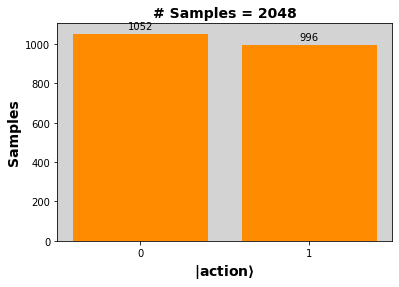

TIME - 1288.366240978241


In [2]:
from qEnvironments import quantum_sparse_sampling as qSS
import numpy as np
import gc
import sys 
import warnings
import time 
warnings.filterwarnings('ignore', category=DeprecationWarning)




ss = 3000 #int(sys.argv[1])
n = 1 # int(sys.argv[2])
horizon = 3
shots = 4096
#n_samples=250

t_init = time.time() 

qGW = qSS(states=Nstates,actions=Nactions,tKernel=tk,gamma=0.9,env="grid")
qGW.step(initState=0,horizon=horizon)
a_dict, a_top , grover_its = qGW.solve(shots=shots, amplify=False, plot_show=True, algorithm="Exponential",outpath="/home/andre/Desktop/qrl",filename="mdp_random_2"+str(ss)+" "+str(n)+".png")

t_end = time.time()
print("TIME - {}".format(t_end-t_init))


In [12]:

A  = []
for i in a_dict.keys():
    A.append(a_dict[i]/n_samples)
    
print(A)

Nexperiments = [3000]*9
NSamples = [1,2,5,10,50,100,200,300,500]

H = np.zeros(len(NSamples))

for n in range(len(NSamples)):
    best_action_c = 0
    count_its = []
    for n_e in range(Nexperiments[n]):
        A_sample_exp = np.zeros(Nactions)
        its_grover = []
        for i in range(NSamples[n]):
            A_sample_exp[np.random.choice(range(Nactions), p=A)]+=1
            its_grover.append(np.random.choice(grover_its))

        if np.argmax(A_sample_exp) == best_action:#) or (np.max(A_sample_exp) == A_sample_exp[best_action]):
            best_action_c += 1
        count_its.append(np.sum(its_grover))

    H[n] = np.mean(count_its) * (best_action_c/Nexperiments[n])    
    

print(H)


'''
import csv

with open('new_mdp2.csv', mode='a') as csv_file:
    fieldnames = ['sample_size' , 'counts']
    writer = csv.writer(csv_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)

    for i in k:
        if not int(i):
            writer.writerow([ss, n_dict[i]])
'''


[0.572, 0.428]
[  0.78554089   2.16530167   4.25087967  10.61052422  58.827396
 125.990592   265.64632733 402.58860833 673.48266667]


'\nimport csv\n\nwith open(\'new_mdp2.csv\', mode=\'a\') as csv_file:\n    fieldnames = [\'sample_size\' , \'counts\']\n    writer = csv.writer(csv_file, delimiter=\',\', quotechar=\'"\', quoting=csv.QUOTE_MINIMAL)\n\n    for i in k:\n        if not int(i):\n            writer.writerow([ss, n_dict[i]])\n'

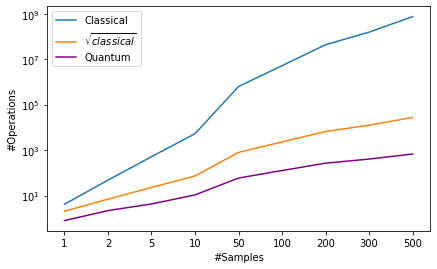

In [50]:
import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline

labels = [str(NSamples) for NSamples in NSamplesList]

x = np.arange(len(labels))  # the label locations

fig, ax = plt.subplots()
rects1 = ax.plot(list(best_action_frequency_dict.values()), label='Classical')
rects1sqrt = ax.plot(np.array(list(best_action_frequency_dict.values()))**(1/2),label=r'$\sqrt{classical}$')

#ax.axhline(y=dist_god[0], color='r', linestyle='-', label="Classic God mode")
#ax.axhline(y=0.374, color='orange', linestyle='-', label="Quantum God mode")
#quantum values for NSamplesList with 50 experiments
quantum_mdp_values = H
rects2 = ax.plot(list(quantum_mdp_values), label='Quantum', color="Purple")

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xlabel('#Samples')
ax.set_ylabel('#Operations')
#ax.set_title('Best action frequencies')
ax.set_xticks(x)
ax.set_xticklabels(labels)
#ax.set_ylim([0., 1.0])
ax.legend()  

fig.tight_layout()
plt.yscale("log")
plt.show()

In [41]:
print('\nDONE ! Ciao for now !! \n')


DONE ! Ciao for now !! 

